In [25]:
import pickle
import numpy as np
import emcee

# Do some Bayesian flaring analysis!

In [4]:
# get likelihood functions, prior distributions
from siberianpine.bayes import calculate_joint_posterior_distribution, uninformative_prior, gaussian_prior

# get the analysis toolkit
from siberianpine.bayes import BayesianFlaringAnalysis

# get the utils
from siberianpine.utils import generate_random_power_law_distribution

### Produce some fake data to work with:

In [9]:
def generate_synthetic_bfa_input(flares_per_day=10., 
                                 mined=100, Tprime=50, deltaT=1.,
                                 alpha_prior=2., threshed=1., cadence=4,
                                 t0=3000., seed=None, maxed=1e4,
                                 estimate_starting_points=False):
    """Generate a dictionary of inputs for 
    BayesianFlaringAnalysis.
    
    Parameters:
    -------------
    flares_per_day : float
        average flaring rate in flares per day
    mined : float
        energy at which the cumulative 
        flare frequency is evaluated
    threshed : float
        detection threshold for flares 
        in the sample (not very well defined
        because it is energy dependent here)
    deltaT : float
        time interval considered for prediction
        of flaring rate above mined
    Tprime : float
        total observation time (light curve length)
        in days
    alpha_prior : float
        prior on alpha (e.g. 2.0)
    cadence : int
        number of observations per hour
    t0 : float
        time offset
    seed : float
        seed the random generator with a number
        if needed
    maxed: float
        set a maximum value for ED, set >> mined
        to simulate a power law without coutoff
    estimate_starting_points : bool, default False
        If True will find MLE for alpha and eps to use as
        starting points for MCMC.

    """
    #time related stuff:
    size = int(np.rint(Tprime*24*cadence))
    obstimes = np.linspace(t0,t0+Tprime,size) # 15 min cadence observations

    times = obstimes[np.where(np.random.poisson(lam=1. / 24. / cadence * flares_per_day,
                                                size=size))[0]]
    Mprime = len(times) # number of events

    #energy related stuff

    # Generate power law distributed data:
    events = generate_random_power_law_distribution(1, maxed, -alpha_prior + 1., size=Mprime, seed=seed)
    threshed = 1 # detection sensitivity limit

    # determine a starting point for the MCMC sampling
    rate_prior = (flares_per_day / np.abs(alpha_prior - 1.) *
                  np.power(mined, -alpha_prior +1.)) # evaluate cumulative FFD fit at mined
    eps_prior = 1 - np.exp(-rate_prior * deltaT) #use Poisson process statistics do get a probability from the rate

    if estimate_starting_points==True:
        # For an uninfromative prior on alpha we expect the MCMC result to be:
        alpha_prior = Mprime / np.sum(np.log(events/threshed)) + 1.

        # determine a starting point for the MCMC sampling
        rate_prior = (flaresperday / np.abs(alpha_prior - 1.) *
                      np.power(mined, -alpha_prior +1.)) # evaluate cumulative FFD fit at mined
        eps_prior = 1 - np.exp(-rate_prior * deltaT) #use Poisson process statistics do get a probability from the rate

    return {"mined":mined, "Tprime":Tprime, "deltaT":deltaT,
            "alpha_prior":alpha_prior, "eps_prior":eps_prior,
            "threshed":threshed, "Mprime":Mprime, "events":events}

# Define a likelihood function and go!

In [90]:
class MixedModel(object):
    """Combine multiple FFDs and fit 
    their parameters simultaneously with
    shared alpha.
    """
    def __init__(self, BFA=[], loglikelihood=None, alpha_prior=None):
        '''Init a Bayesian analysis suite. NOT TESTED.'''
        self.BFA = BFA
        self.loglikelihood = loglikelihood
        self.alpha_prior = alpha_prior
        
    def sample_posterior_with_mcmc(self, nwalkers=3000, cutoff=100, steps=500):
        '''Sample from the posterior using MCMC.

        Parameters:
        -------------
        inits : list
            initial variable values in the correct order
            for lnprob
        lnprob : func
            posterior distribution that takes
            inits as first argument and *args as second
            to last arguments
        nwalkers : int
            number of walkers to run around the parameter space
        cutoff : int
            You do not want to use values in the beginning
            of the chain, so cut them off.
        steps : int
            How long to run the walk.

        Return:
        --------
        Sampling results as ndarray with dimensions like
        len(init) x ((steps - cutoff) * nwalkers)
        '''

        args, inits = [], []
        
        for bfa in BFA:
            args.append([bfa.mined, bfa.Tprime, bfa.Mprime,
                         bfa.deltaT, bfa.threshed, bfa.M,
                         bfa.events])
            inits.append(bfa.eps_prior)
            
        inits.append(self.alpha_prior)    
        
        args = [i for i in args if i is not None]
        inits = [i for i in inits if i]
        
        ndim = len(inits)
        pos = [inits + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
        #print(pos)
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.loglikelihood, args=args)
        sampler.run_mcmc(pos, steps)

        self.samples = sampler.chain[:, cutoff:, :].reshape((-1, ndim))

        

In [91]:
# mix and match priors into your final posterior
def mixedmodel_loglikelihood(theta, *args):
    '''Custom likelihood to pass to BayesianFlaringAnalysis'''
    def prior(x):
        return gaussian_prior(x, 1.8, 2.2)
    posterior = 0
    for i, beta in enumerate(theta[:-1]):
        posterior += calculate_joint_posterior_distribution([beta, theta[-1]], *args[i], prior)
    return posterior

In [93]:
BFA = [BayesianFlaringAnalysis(**generate_synthetic_bfa_input(flares_per_day=i)) for i in range(15,18)]
MM = MixedModel(BFA=BFA, loglikelihood=loglikelihood, alpha_prior=2.)

In [94]:
# Run MCMC to sample the posterior distribution
MM.sample_posterior_with_mcmc()

In [95]:
truths = []
for bfa in BFA:
    truths.append(bfa.eps_prior)
truths.append(2.)

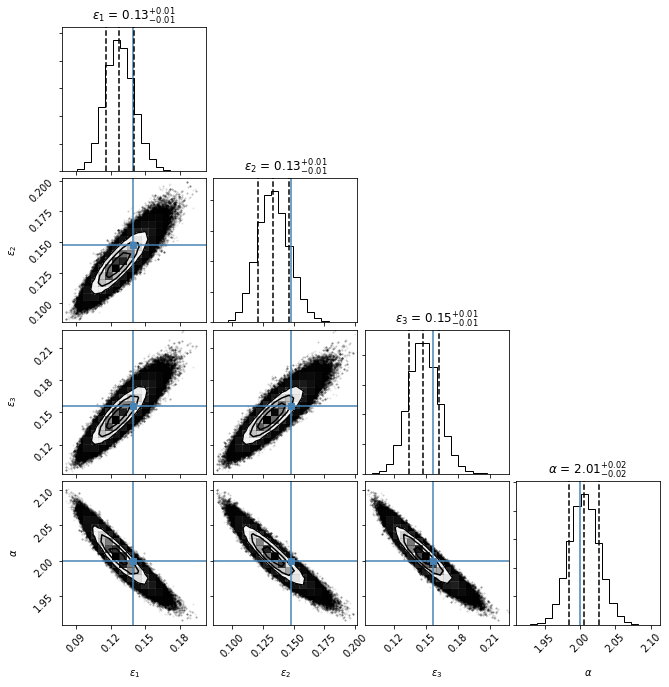

In [97]:
import corner
fig = corner.corner(MM.samples, labels=(r'$\epsilon_1$',r'$\epsilon_2$',r'$\epsilon_3$', r'$\alpha$'),
                            quantiles=[0.16, 0.5, 0.84],
                            show_titles=True, title_kwargs={"fontsize": 12},
                            truths=truths,
                            title="hello")

# For flare we so far have two dimensions fixed
ndim =4

# Extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    #ax.axvline(self.alpha_prior, color="g")
    #ax.axvline(self.eps_prior, color="g")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
     #   ax.axvline(self.eps_prior, color="g")
      #  ax.axhline(self.alpha_prior, color="g")
      #  ax.plot(self.eps_prior, self.alpha_prior, "sg")

fig.savefig("mixelmodel_posterior.png", dpi=300)